In [108]:
def jobs_manager():
    from IPython.lib.backgroundjobs import BackgroundJobManager
    from IPython.core.magic import register_line_magic
    from IPython import get_ipython

    jobs = BackgroundJobManager()

    @register_line_magic
    def job(line):
        ip = get_ipython()
        jobs.new(line, ip.user_global_ns)

    return jobs
import sys
import argparse
import random
from nile.api.v1 import (
    clusters,
    Record,
    filters as nf,
    aggregators as na,
    grouping as ng,
    extractors as ne,
    statface as ns
)
from qb2.api.v1 import (
    filters as sf,
    extractors as se,
    resources as sr
)
import nile
import urlparse
import json
from itertools import product
from nile.api.v1 import datetime as nd
import re
import pandas as pd
import random
import string
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.plotly as py
import plotly.figure_factory as ff

In [20]:
cluster = clusters.YT(proxy="hahn.yt.yandex.net", pool="voice") \
                .env(templates=dict(
                                job_root=('home/voice/talamable/VA-620'),
                                dates='{2019-03-25..2019-03-31}'))

In [14]:
def aggregate_external_statistics(records):
    for rec in records:
        is_ext = False
        ext_props ={
            'skill_id': '',
            'time': 0.,
            'moves': 0.,
            'uuid': rec['uuid'],
            'fielddate': rec['fielddate'],
            'session_id': rec['session_id']
        }
        for item in rec['session']:
            if 'external_skill' in item['intent']:
                if item.get('skill_id') is None:
                    continue
                if is_ext:
                    if item.get('skill_id') == ext_props['skill_id']:
                        ext_props['time'] += item['delta']
                        ext_props['moves'] += 1
                    else:
                        yield Record(**ext_props)
                        ext_props = {
                            'skill_id': item['skill_id'],
                            'time': 0.,
                            'moves': 1.,
                            'uuid': rec['uuid'],
                            'fielddate': rec['fielddate'],
                            'session_id': rec['session_id']
                        }
                else:
                    is_ext = True
                    ext_props = {
                            'skill_id': item['skill_id'],
                            'time': 0.,
                            'moves': 1.,
                            'uuid': rec['uuid'],
                            'fielddate': rec['fielddate'],
                            'session_id': rec['session_id']
                        }
            else:
                if is_ext:
                    yield Record(**ext_props)
                    ext_props = {
                            'skill_id': '',
                            'time': 0.,
                            'moves': 0.,
                            'uuid': rec['uuid'],
                            'fielddate': rec['fielddate'],
                            'session_id': rec['session_id']
                        }
                is_ext = False

In [101]:
job = cluster.job()
ext_stat = job.table('home/voice/dialog/sessions/@dates') \
              .filter(nf.or_(nf.equals('app', 'search_app_prod'), 
                             nf.equals('app', 'browser_prod'))) \
              .map(aggregate_external_statistics) \
              .filter(nf.custom(lambda x: x > 3, 'moves')) \
              .groupby('skill_id') \
              .aggregate(users = na.count_distinct('uuid'),
                         total_time_spent = na.sum('time'),
                         total_moves = na.sum('moves'),
                         games = na.count(),
                         sessions = na.count_distinct('session_id'),
                         time_dist = na.quantile_estimate('time', [0, 0.25, 0.5, 0.8, 1]),
                         moves_dist = na.quantile_estimate('moves', [0, 0.25, 0.5, 0.8, 1]),
                         long_games_1m = na.count(predicate=nf.custom(lambda x: x>60, 'time')),
                         long_games_2m = na.count(predicate=nf.custom(lambda x: x>120, 'time')),
                         long_games_5m = na.count(predicate=nf.custom(lambda x: x>300, 'time')),
                         long_games_10mov = na.count(predicate=nf.custom(lambda x: x>10, 'moves')),
                         long_games_15mov = na.count(predicate=nf.custom(lambda x: x>15, 'moves')),
                         long_games_20mov = na.count(predicate=nf.custom(lambda x: x>20, 'moves'))
                        )
skill_names = job.table('home/paskills/skills/stable').project('id', 'name', 'developerType', 'categoryLabel', 'category', 'channel').filter(nf.equals('category', 'games_trivia_accessories'),
                nf.equals('developerType', 'external'),
                nf.equals('channel', 'aliceSkill'),
               ) 
ext_stat.join(skill_names, by_left='skill_id', by_right='id') \
        .put('$job_root/skills_stats_mobile')
job.run()

INFO:qb2.api.v1.qb:Creating QB2 with log table <class 'qb2.api.v1.logs.generic.GenericLog'>
INFO:qb2.typing.inference:BEGIN type inference
INFO:qb2.typing.inference:END type inference
INFO:qb2.api.v1.qb:Creating QB2 with log table <class 'qb2.api.v1.logs.generic.GenericLog'>
INFO:qb2.typing.inference:BEGIN type inference
INFO:qb2.typing.inference:END type inference
INFO:qb2.api.v1.qb:Creating QB2 with log table <class 'qb2.api.v1.logs.generic.GenericLog'>
INFO:qb2.typing.inference:BEGIN type inference
INFO:qb2.typing.inference:END type inference
INFO:qb2.api.v1.qb:Creating QB2 with log table <class 'qb2.api.v1.logs.generic.GenericLog'>
INFO:qb2.typing.inference:BEGIN type inference
INFO:qb2.typing.inference:END type inference
INFO:qb2.api.v1.qb:Creating QB2 with log table <class 'qb2.api.v1.logs.generic.GenericLog'>
INFO:qb2.typing.inference:BEGIN type inference
INFO:qb2.typing.inference:END type inference
INFO:qb2.api.v1.qb:Creating QB2 with log table <class 'qb2.api.v1.logs.generic.G

INFO:nile.api.v1.job:Running execution plan...


VBox()

INFO:nile.drivers.common.context:Stashing attributes ('input', 'raw_input', 'get_ipython') from __builtin__...
INFO:nile.drivers.common.execution_plan:Preparing commands...
INFO:nile.drivers.common.execution_plan:Preparing command [1/28]...
INFO:nile.drivers.common.execution_plan:Preparing command [2/28]...
INFO:nile.drivers.common.script:Creating function script with run_command_prefix None and python binary python...
INFO:nile.drivers.common.script:Saved script function code into '/tmp/nilescript-Aqrl2O/code.pickle-EyKcbM'.
INFO:nile.drivers.common.script:Saved pickle text dump into '/tmp/nilescript-Aqrl2O/code.txt-NqGYVj'.
INFO:qb2.api.v1.qb:Creating QB2 with log table <class 'qb2.api.v1.logs.generic.GenericLog'>
INFO:qb2.typing.inference:BEGIN type inference
INFO:qb2.typing.inference:END type inference
INFO:nile.drivers.yt.qb2:Preparing qb2 slices...
INFO:nile.drivers.yt.qb2:Applying columns reader optimization...
INFO:nile.drivers.common.execution_plan:Preparing command [3/28]...


INFO:nile.drivers.common.script:Saved pickle text dump into '/tmp/nilescript-OlCmMX/code.txt-vHXHXh'.
INFO:nile.drivers.common.script:Creating function script with run_command_prefix None and python binary python...
INFO:nile.drivers.common.script:Saved script function code into '/tmp/nilescript-_0NuCH/code.pickle-tCWxUx'.
INFO:nile.drivers.common.script:Saved pickle text dump into '/tmp/nilescript-_0NuCH/code.txt-a4NtSY'.
INFO:nile.drivers.common.execution_plan:Preparing command [16/28]...
INFO:nile.drivers.common.script:Creating function script with run_command_prefix None and python binary python...
INFO:nile.drivers.common.script:Saved script function code into '/tmp/nilescript-a6XDjf/code.pickle-ZS5CpH'.
INFO:nile.drivers.common.script:Saved pickle text dump into '/tmp/nilescript-a6XDjf/code.txt-zUuB5q'.
INFO:nile.drivers.common.execution_plan:Preparing command [17/28]...
INFO:nile.drivers.common.script:Creating function script with run_command_prefix None and python binary python

INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/nilescript-Aqrl2O/code.pickle-EyKcbM', filename='code.pickle-EyKcbM', executable=False, add_to_archive=None) -> TempLocalFile(path='/tmp/nilescript-Aqrl2O/code.pickle-EyKcbM', filename='code.pickle-EyKcbM', executable=False, add_to_archive=None)
INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/nilescript-Aqrl2O/code.txt-NqGYVj', filename='code.txt-NqGYVj', executable=False, add_to_archive=None) -> TempLocalFile(path='/tmp/nilescript-Aqrl2O/code.txt-NqGYVj', filename='code.txt-NqGYVj', executable=False, add_to_archive=None)
INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/nilescript-Aqrl2O/requirements-L7Eu_U', filename='requirements-L7Eu_U', executable=False, add_to_archive=True) -> TempLocalFile(path='/tmp/nilescript-Aqrl2O/requirements-L7Eu_U', filename='requirements-L7Eu_U', executable=False, add_to_archive=True)
INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/ni

INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/nilescript-a6XDjf/code.pickle-ZS5CpH', filename='code.pickle-ZS5CpH', executable=False, add_to_archive=None) -> TempLocalFile(path='/tmp/nilescript-a6XDjf/code.pickle-ZS5CpH', filename='code.pickle-ZS5CpH', executable=False, add_to_archive=None)
INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/nilescript-a6XDjf/code.txt-zUuB5q', filename='code.txt-zUuB5q', executable=False, add_to_archive=None) -> TempLocalFile(path='/tmp/nilescript-a6XDjf/code.txt-zUuB5q', filename='code.txt-zUuB5q', executable=False, add_to_archive=None)
INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/nilescript-a6XDjf/requirements-5o1NFW', filename='requirements-5o1NFW', executable=False, add_to_archive=True) -> TempLocalFile(path='/tmp/nilescript-a6XDjf/requirements-5o1NFW', filename='requirements-5o1NFW', executable=False, add_to_archive=True)
INFO:nile.drivers.common.execution_plan:- TempLocalFile(path='/tmp/ni

INFO:nile.drivers.common.execution_plan:- LocalFile(path='/usr/lib/python2.7/dist-packages/signurl_bindings/wheelhouse/signurl_bindings-0.3.1-cp27-cp27mu-linux_x86_64.whl', filename='signurl_bindings-0.3.1-cp27-cp27mu-linux_x86_64.whl', executable=False, add_to_archive=None) -> TempLocalFile(path='/tmp/nile-tmp-filesenr1d3/signurl_bindings-0.3.1-cp27-cp27mu-linux_x86_64.whl', filename='signurl_bindings-0.3.1-cp27-cp27mu-linux_x86_64.whl', executable=False, add_to_archive=None)
INFO:nile.drivers.common.execution_plan:- LocalFile(path='/usr/lib/python2.7/dist-packages/statbox_bindings2/wheelhouse/statbox_bindings2-0.24.2-cp27-cp27mu-linux_x86_64.whl', filename='statbox_bindings2-0.24.2-cp27-cp27mu-linux_x86_64.whl', executable=False, add_to_archive=None) -> TempLocalFile(path='/tmp/nile-tmp-filesenr1d3/statbox_bindings2-0.24.2-cp27-cp27mu-linux_x86_64.whl', filename='statbox_bindings2-0.24.2-cp27-cp27mu-linux_x86_64.whl', executable=False, add_to_archive=None)
INFO:nile.drivers.common.ex

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTMap(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_settings={'de

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTMap(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_settings={'de

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTReduceCombine(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_set

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTMap(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_settings={'de

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTReduceCombine(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_set

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTReduceCombine(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_set

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTReduce(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_settings={

INFO:nile.drivers.common.command:- Populating requirements for command: ↵
YTReduce(
    driver=YTDriver(
        proxy='hahn.yt.yandex.net',
        token='...',
        pool='voice',
        clean_cache=False),
    environment=Environment(
        files=frozenset(),
        templates={'checkpoints_root': '$tmp/checkpoints',
         'dates': '{2019-03-25..2019-03-31}',
         'job_name': 'e2025310-5676-11e9-9fb9-77c362378739',
         'job_root': 'home/voice/talamable/VA-620',
         'job_uuid': 'e2025310-5676-11e9-9fb9-77c362378739',
         'title': 'Nile job $job_name (step $current_step / $total_steps)',
         'tmp': '$tmp_root/$job_uuid',
         'tmp_files': '$tmp/files',
         'tmp_root': 'tmp/nile/$user_name',
         'user_name': u'talamable'},
        statbox_wheels_search_order=('.',),
        output_table_paths_prefix=<undefined>,
        run_command_prefix=None,
        default_memory_limit=512,
        default_add_to_archive=True,
        publish_settings={

INFO:nile.drivers.yt.execution_plan:Running command [8/15]...
INFO:nile.drivers.yt.command:Unsorted reduce...
INFO:nile.drivers.yt.utils:- Initial memory limit: 536870912
INFO:nile.drivers.yt.utils:Increasing memory limit...
INFO:nile.drivers.yt.utils:- Final memory limit: 815702223L
INFO:nile.drivers.yt.utils:- Initial memory limit: 536870912
INFO:nile.drivers.yt.utils:Increasing memory limit...
INFO:nile.drivers.yt.utils:- Final memory limit: 815702223L
INFO:nile.drivers.common.progress:Completed <class 'nile.drivers.yt.command.YTReduce'>.
INFO:nile.drivers.common.progress:Completed <class 'nile.drivers.yt.extra_command.YTRemove'>.
INFO:nile.drivers.yt.execution_plan:Running command [9/15]...
INFO:nile.drivers.yt.utils:- Initial memory limit: 536870912
INFO:nile.drivers.yt.utils:Increasing memory limit...
INFO:nile.drivers.yt.utils:- Final memory limit: 815702223L
INFO:nile.drivers.common.progress:Completed <class 'nile.drivers.yt.command.YTMap'>.
INFO:nile.drivers.common.progress:Co

In [103]:
df = job.table('//home/voice/talamable/VA-620/skills_stats_mobile').read().as_dataframe().fillna(0)
df['median_time'] = [x[2][1] for x in df['time_dist']]
df['median_moves'] = [x[2][1] for x in df['moves_dist']]
df['profit_2m'] = [round(x*(0.4*30/7.), 0) for x in df['long_games_2m']]
df['profit_5m'] = [round(x*(0.4*30/7.), 0) for x in df['long_games_5m']]
df['profit_15mov'] = [round(x*(0.4*30/7.), 0) for x in df['long_games_15mov']]
df['profit_20mov'] = [round(x*(0.4*30/7.), 0) for x in df['long_games_20mov']]

In [121]:
print 'Игр >1 минуты: %d\nИгр >2 минут: %d\nИгр >5 минут: %d'%(sum(df['long_games_1m']),
                                                                  sum(df['long_games_2m']),
                                                                  sum(df['long_games_5m'])
                                                                 )
print 'Игр >10 ходов: %d\nИгр >15 ходов: %d\nИгр >20 ходов: %d'%(sum(df['long_games_10mov']),
                                                                  sum(df['long_games_15mov']),
                                                                  sum(df['long_games_20mov'])
                                                                 )

Игр >1 минуты: 342965
Игр >2 минут: 236172
Игр >5 минут: 110578
Игр >10 ходов: 264236
Игр >15 ходов: 193297
Игр >20 ходов: 146630


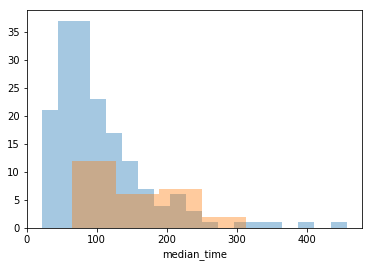

In [131]:
sns.distplot(df['median_time'], kde=False)
sns.distplot(df[df['users']>1000]['median_time'], kde=False)

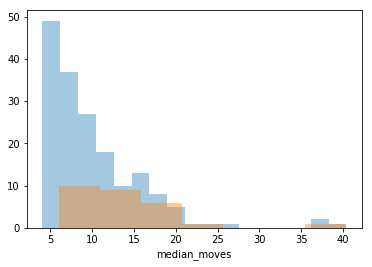

In [130]:
sns.distplot(df['median_moves'], kde=False)
sns.distplot(df[df['users']>1000]['median_moves'], kde=False)

In [104]:
df[df['users']>1000].describe()

,games,long_games_10mov,long_games_15mov,long_games_1m,long_games_20mov,long_games_2m,long_games_5m,sessions,total_moves,total_time_spent,users,median_time,median_moves,profit_2m,profit_5m,profit_15mov,profit_20mov
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,2.700000e+01,2.700000e+01,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,15156.481481,9454.370370,6928.851852,12208.888889,5262.259259,8445.333333,3971.851852,13565.000000,4.074868e+05,4.121798e+06,12291.925926,147.687387,13.214523,14477.629630,6808.888889,11878.000000,9021.111111
std,20385.961050,14559.224747,12344.860643,16699.262866,10949.038980,12754.952191,7774.445198,17851.301019,9.444155e+05,7.154206e+06,15993.741514,69.111502,6.723186,21865.579519,13327.693768,21162.684323,18769.779777
min,1215.000000,271.000000,72.000000,818.000000,24.000000,332.000000,27.000000,1123.000000,1.303300e+04,1.598270e+05,1074.000000,64.656463,6.000000,569.000000,46.000000,123.000000,41.000000
25%,1752.500000,896.000000,514.500000,1384.000000,252.500000,832.500000,211.000000,1709.500000,2.703150e+04,3.183660e+05,1583.000000,82.085046,8.500000,1427.000000,361.500000,882.000000,433.000000
50%,2765.000000,1556.000000,1223.000000,2209.000000,764.000000,1548.000000,578.000000,2584.000000,7.384900e+04,8.675190e+05,2384.000000,148.410156,13.218419,2654.000000,991.000000,2097.000000,1310.000000
75%,24412.500000,15253.000000,10456.000000,21515.000000,6064.500000,15999.000000,3922.500000,23014.500000,4.278575e+05,6.221314e+06,21469.000000,201.153543,16.000000,27427.000000,6724.500000,17924.500000,10396.000000
max,77527.000000,64188.000000,59672.000000,67781.000000,54780.000000,57679.000000,35785.000000,63079.000000,4.877482e+06,3.264126e+07,52434.000000,312.810680,40.393016,98878.000000,61346.000000,102295.000000,93909.000000


In [105]:
df.nlargest(15, 'long_games_2m')[['name', 'users', 'profit_2m', 'profit_5m', 'profit_15mov', 'profit_20mov', 'median_time', 'median_moves']]

,name,users,profit_2m,profit_5m,profit_15mov,profit_20mov,median_time,median_moves
169,Угадай персонажа,52434,98878.0,61346.0,102295.0,93909.0,268.211610,40.393016
162,Сто к одному,23604,45903.0,32806.0,38186.0,32278.0,312.810680,20.856836
131,"Да, милорд",26369,37874.0,21129.0,25476.0,19047.0,207.358990,13.904793
98,Одно из двух,19334,29571.0,13068.0,23287.0,14726.0,225.841948,17.176801
76,Камень-ножницы-бумага,44173,29474.0,5469.0,27302.0,17314.0,89.951072,11.000000
60,Закончи пословицу,23717,28935.0,13195.0,22035.0,16584.0,147.454203,13.218419
129,Числовые фокусы,24128,28164.0,10250.0,13814.0,8415.0,152.476698,10.000000
82,"Игра ""Крокодил""",51764,26690.0,4653.0,25925.0,12377.0,85.704718,11.048661
111,Викторина Пандарина,19087,22755.0,7980.0,10930.0,6849.0,157.993114,10.976294
34,Монстры на каникулах 3: море зовёт,8335,7311.0,1836.0,8757.0,6854.0,106.178595,16.084513
